In [2]:
!pip install pydrive
!pip install pydub
!pip install audiomentations
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
## Data storage and collection dependencies ##
from bs4 import BeautifulSoup
import requests
import csv
import boto3
import pandas as pd
import requests
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")
import pickle

## Audio processing and augmentation dependencies ##
from pydub.audio_segment import read_wav_audio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import soundfile as sf
from audiomentations import Trim, TimeMask, HighPassFilter, Resample
import sklearn

## Modeling dependencies ##



## Data Augementation

*   Now that we have our files stored, we need to augment the data. 
  *   Because we are using computer vision to classify spectrograms, we need to transform the data itself
  *   It is much easier to augment the raw audio data, rather than the image of the spectogram
* Augmenting audio data in this way produces much better results on average, because neural networks are very data hungry
* By augmenting the data, **we reduce overfitting and make our model more robust to variations in audio quality** by providing more samples to learn from



### Audito Augmentation Functions with Librosa and Audiomentations

In [4]:
from pydub import AudioSegment
from pydub.audio_segment import read_wav_audio
import numpy as np
import librosa
import soundfile as sf
from audiomentations import Trim, TimeMask, HighPassFilter, Resample

#audiomentation transformations
  #Using these for some more complex transformations that librosa doesn't have, or ones I am not sure how to do on my own


#Trim empty audio space at beginning and end, applied to almost all
transform_trim = Trim(p=1.0) 

#Randomly remove a subsection of the data to be empty 
transform_mask = TimeMask(  
    min_band_part = 0.02,
    max_band_part = 0.05,
    fade = True,
    p = 0.2
)

#Attenuates low frequencies and passes high frequencies, we can randomize the cutoffs
  #min of 20, max of 2400
transform_high_pass = HighPassFilter(
    min_cutoff_freq = 20.0,
    max_cutoff_freq = 2400.0,
    min_rolloff = 12.0,
    max_rolloff = 24.0,
    zero_phase = False,
    p = 0.4
)

# transform_resample = Resample(p=1.0)

#White Noise
  #noise_factor of 0 as mean, normally distributed between -.2 and .2
def add_white_noise(signal, noise_factor):
  noise = np.random.normal(0, signal.std(), signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

#Time Stretch
  #stretch_factor of 1 as mean, normally distributed between .9 to 1.1 
def add_time_stretch(signal, stretch_factor):
  return librosa.effects.time_stretch(signal, stretch_factor)

#Pitch Scaling
  #pitch_factor of 0 as mean, values are between -4 and 4 preferably, but only as integers
def add_pitch_scaling(signal, sr, pitch_factor):
  return librosa.effects.pitch_shift(signal, sr, pitch_factor)

#Polarity Inversion
  #no input needed, apply or don't apply
def add_polarity_inversion(signal, p):
  p = [1-p, p]
  polarity = np.random.choice([1, -1], p= p)
  return signal * polarity

#Random Gain
  #
def add_random_gain(signal, min_gain_factor, max_gain_factor, p):
  p = [1-p, p]
  if np.random.choice([0, 1], p= p) == 1:
    gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
  else:
    gain_factor = 1
  return signal * gain_factor


pitch_factor_list = np.linspace(-4, 4, 9)
pitch_factor_weights = [0.05, 0.05, .1, .15, .3, .15, .1, .05, .05]
min_gain_factor = 2
max_gain_factor = 5


#Some random variables

def create_audio_copies(signal):
  signal_copies = []
  random = np.random.uniform()
  if random <= .33:
    copies = 0
  elif random <= .66:
    copies = 1
  else:
    copies = 2
  
  for i in range(copies):
    signal_copies.append(signal)

  return signal_copies

def apply_random_transformation(signal, sr):
#Reduce data to same length

#Initialize parameters
  pitch_factor_list = np.linspace(-4, 4, 9)
  pitch_factor_weights = [0.05, 0.05, .1, .15, .3, .15, .1, .05, .05]
  min_gain_factor = 2
  max_gain_factor = 5

#define random variables
  noise_factor = np.random.normal(0, .1)
  # stretch_factor = np.random.normal(1, .05)
  pitch_factor = np.random.choice(pitch_factor_list, p = pitch_factor_weights)

#apply functions with the necessary random inputs
  signal = add_pitch_scaling(signal, sr, pitch_factor)
  signal = add_white_noise(signal, noise_factor)
  signal = add_polarity_inversion(signal, np.random.uniform())
  signal = add_random_gain(signal, min_gain_factor, max_gain_factor, np.random.uniform())
  signal = transform_mask(signal, sr)
  signal = transform_high_pass(signal, sr)
  
#return original, and the transformed signal/signals
  return signal, sr




### Visualization and image representation of audio clips


*   We'll use different images on each axis as our version of features for this problem
*   Alot of the work/ideas here are borrowed from this [paper](https://arxiv.org/pdf/2010.03136.pdf)
*   Primarily working with librosa library - https://librosa.org/doc/main/feature.html



I want to create two axis of inputs, one for stft based image representations, and another of simple arrays of audio features

In [5]:
## STFT axis ##
def tf_mlsgram(signal, sr):
  sgram = librosa.stft(signal) #apply short-time fourier transform to separated time frames
    #transforms to the frequency domain instead of time
    #n_fft=2028 #hop_length = 512
  magphase, _ = librosa.magphase(sgram)
  mel_sgram = librosa.feature.melspectrogram(S= magphase, sr= sr) #convert to mel scale, which puts the values on something similar to a log scale
  mel_sgram = librosa.amplitude_to_db(mel_sgram, ref=np.min) #change amplitude to something that represent more clearly visually

  return mel_sgram, sr

def tf_mfcc(signal, sr):
  mfcc = librosa.feature.mfcc(signal, sr=sr)
  # Center MFCC coefficient dimensions to the mean and unit variance
  mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

  return mfcc, sr

#Chromatic scale short time fourier transformation
  #Get the pitch relationships
def tf_chroma_stft(signal, sr):
  chroma_stft = librosa.feature.chroma_stft(signal, sr=sr)
  return chroma_stft, sr

## Non STFT axis ##

#Zero-crossing rate. Measures variations and can capture certain characteristics like percusive features
def tf_zcr(signal, sr):
  zcr = librosa.feature.zero_crossing_rate(signal).T
  return zcr, sr

#Spectral Bandwidth
def tf_spec_bw(signal, sr):
  bw = librosa.feature.spectral_bandwidth(signal, sr=sr)
  return bw, sr

#Spectral Centroid
def tf_spec_cent(signal, sr):
  cent = librosa.feature.spectral_centroid(signal, sr=sr)
  return cent, sr


## Display Functions ##
def show_chroma(chroma, sr):
  img = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
  plt.colorbar(img)

def show_zcr(zcr):
  plt.plot(zcr)

def show_bw(bw):
  plt.plot(bw.T)

def show_cent(cent):
  plt.plot(cent.T)

def show_mlsgram(mel_sgram, sr):
  librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

def show_mfcc(mfcc, sr):
  librosa.display.specshow(mfcc, sr=sr, x_axis='time')
  print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')


### Single run through - Augmentation, Visualization

*   In order to get a better feel for what we are trying to do with the audio augmentations, let's run it through on just one sample
*   We will walk through and visualize how these audio augmentations might transform the data
   * Note that in the real transformations, the functions will be applied in a random manner to get a good distribution of transformations
* We do not want to muddy the data too much, it should still be clearly audible and not too distorted



In [6]:
#Download mp3 and export it as a wav file which is easier to work from and to listen to inside of Jupyter

src = '/content/2-3.mp3'
dst = 'test.wav'

sound = AudioSegment.from_mp3(src)
sound.export(dst, format = 'wav')

<_io.BufferedRandom name='test.wav'>

In [7]:
signal, sr = librosa.load('/content/test.wav')
sound = AudioSegment.from_wav('/content/test.wav')

signal_aug, sr_aug = apply_random_transformation(signal, sr)
sf.write("test_augmented.wav", signal_aug, sr_aug)
sound_aug = AudioSegment.from_wav('/content/test_augmented.wav')

In [8]:
sound

In [9]:
sound_aug

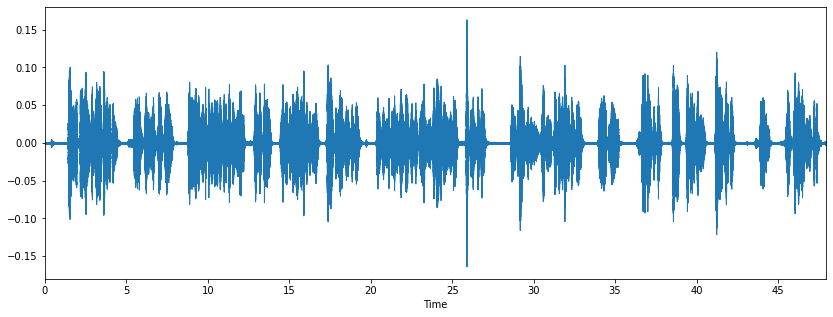

In [10]:


plt.figure(figsize = (14, 5))
librosa.display.waveplot(signal_aug, sr)


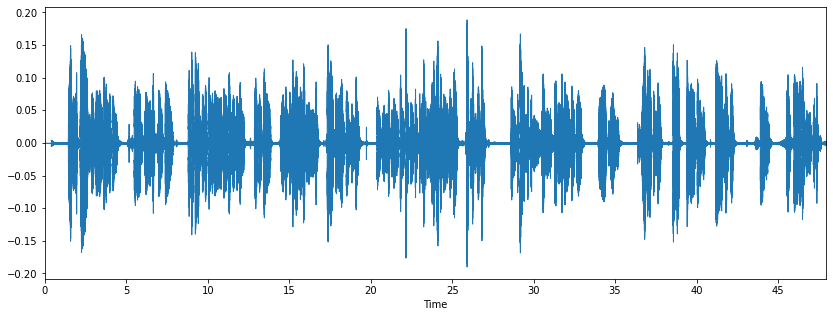

In [11]:
plt.figure(figsize = (14, 5))
librosa.display.waveplot(signal, sr)

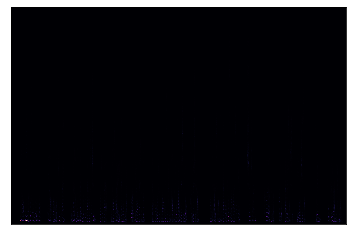

In [14]:
sgram = librosa.stft(signal)
sgram_aug = librosa.stft(signal_aug)
librosa.display.specshow(sgram)

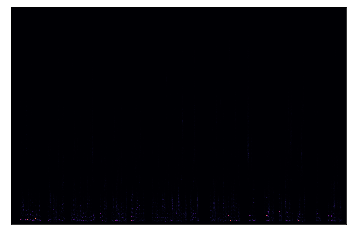

In [15]:
librosa.display.specshow(sgram_aug)

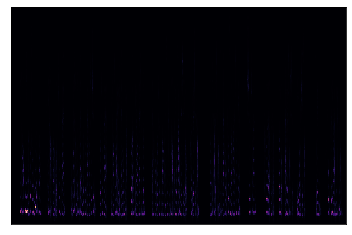

In [16]:
sgram_mag, _ = librosa.magphase(sgram)
sgram_mag_aug, _ = librosa.magphase(sgram_aug)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
mel_scale_sgram_aug = librosa.feature.melspectrogram(S = sgram_mag_aug, sr=sr)
librosa.display.specshow(mel_scale_sgram)

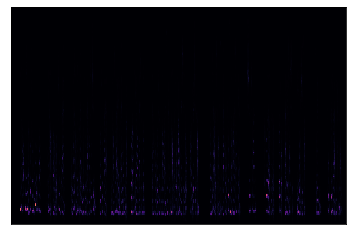

In [17]:
librosa.display.specshow(mel_scale_sgram_aug)

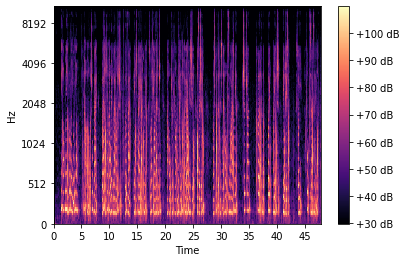

In [18]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
mel_sgram_aug = librosa.amplitude_to_db(mel_scale_sgram_aug, ref = np.min)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

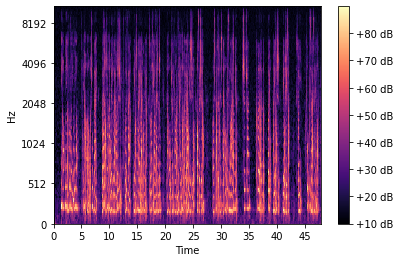

In [19]:
librosa.display.specshow(mel_sgram_aug, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

MFCC is of type <class 'numpy.ndarray'> with shape (20, 2066)


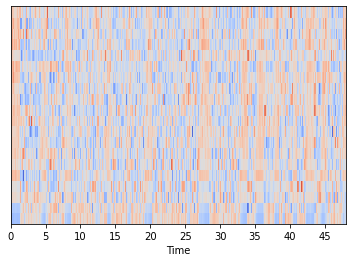

In [20]:
import sklearn
mfcc = librosa.feature.mfcc(signal_aug, sr=sr)

# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')

MFCC is of type <class 'numpy.ndarray'> with shape (20, 2066)


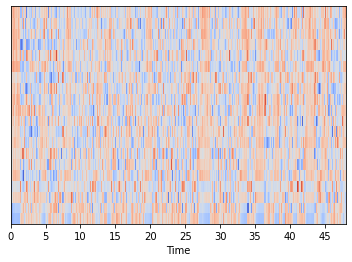

In [21]:
mfcc = librosa.feature.mfcc(signal, sr=sr)

# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')

First, let's try using only one feature as a baseline, the MFCC